## Исследование рынка общественного питания в Москве

Необходимо выявить взаимосвязи следующих признаков заведений:
- Наличие сети;
- Территориальное расположение;
- Тип заведения;
- Численность посадочных мест.

[Первичный анализ данных.](#step1)

[Анализ данных.](#step2)
 - [Соотношение видов объектов](#type_object)
 - [Поиск закономерностей в сетевых заведениях](#network)
 - [Выявление популярных районов](#pop_districts)
 - [Выявление закономерностей заведений в популярных районов](#pop_districts_depend)
 - [Выявление районов с улицами, на которых один вид заведений](#districts_1_inst)
 
[Общий вывод](#conclusion)


## Первичный анализ данных. <a name="step1"></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import itertools
import requests
from io import BytesIO
pd.options.mode.chained_assignment = None

In [2]:
pd.set_option('display.max_colwidth', -1)
api_key = 'c83d11b5-7906-4d02-a13b-ef304960c16e'

In [3]:
rest_df = pd.read_csv('/datasets/rest_data.csv')
rest_df['object_name'] = rest_df['object_name'].str.lower()
rest_df['object_name'] = rest_df['object_name'].str.replace(r'[«».]*', '')
rest_df['object_name'] = rest_df['object_name'].str.replace(r'-', ' ')
rest_df.replace({"object_type": {'предприятие быстрого обслуживания':'бистро',
                            'магазин (отдел кулинарии)': 'магазин'}}, inplace=True)

print('{} - количество дубликатов с различными id'.format(rest_df.loc[:, 'object_name': 'number'].duplicated().sum()))
legal_name_type_objects = rest_df['object_type'].unique()
rest_df.info() 
rest_df.head()

85 - количество дубликатов с различными id
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


,id,object_name,chain,object_type,address,number
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,кафе академия,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,кафе вишневая метель,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


Таблица состоит из следующих столбцов:

* id — идентификатор объекта;
* object_name — название объекта общественного питания;
* chain — сетевой ресторан;
* object_type — тип объекта общественного питания;
* address — адрес;
* number — количество посадочных мест.

Заменил 'предприятие быстрого обслуживания' на 'бистро', 'магазин (отдел кулинарии)' на 'магазин' для более простой обработки. Пропуски отсутствуют. Дубликаты обнаружены, исследуем их.

In [4]:
print('{} - id первой повторяющейся записи '.format(rest_df.loc[:, 'object_name': 'number'].
                duplicated()[rest_df.loc[:, 'object_name': 'number'].duplicated()].index[0]))

print('Рассмотрим значения вокруг первого повтора')
rest_df.query('object_name == "комбинат питания мгту имнэбаумана"')

2381 - id первой повторяющейся записи 
Рассмотрим значения вокруг первого повтора


,id,object_name,chain,object_type,address,number
113,28608,комбинат питания мгту имнэбаумана,нет,буфет,"город Москва, Бригадирский переулок, дом 3-5",34
114,28613,комбинат питания мгту имнэбаумана,нет,закусочная,"город Москва, Бригадирский переулок, дом 3-5",216
115,28614,комбинат питания мгту имнэбаумана,нет,буфет,"город Москва, Бригадирский переулок, дом 3-5",12
2374,28603,комбинат питания мгту имнэбаумана,нет,столовая,"город Москва, 2-я Бауманская улица, дом 5, строение 1",100
2375,28604,комбинат питания мгту имнэбаумана,нет,столовая,"город Москва, 2-я Бауманская улица, дом 5, строение 1",150
2376,28605,комбинат питания мгту имнэбаумана,нет,кафетерий,"город Москва, 2-я Бауманская улица, дом 5, строение 1",35
2377,28606,комбинат питания мгту имнэбаумана,нет,буфет,"город Москва, 2-я Бауманская улица, дом 5, строение 1",16
2378,28607,комбинат питания мгту имнэбаумана,нет,закусочная,"город Москва, 2-я Бауманская улица, дом 5, строение 1",16
2379,28609,комбинат питания мгту имнэбаумана,нет,буфет,"город Москва, 2-я Бауманская улица, дом 5, строение 1",30
2380,28610,комбинат питания мгту имнэбаумана,нет,столовая,"город Москва, 2-я Бауманская улица, дом 5, строение 1",200


Есть как полностью повторяющиеся значения, вплоть до числа мест в заведении, также есть и минимальные отличия заведений, но при проверке заведений общественного питания на примере МГТУ было выявлено по данным на сайте самого комбината, что это не повторы, а действительно различные заведения, при дальнейшей обработке будем исходить из утверждения о том, что подобные заведения различны. 

Однако для собственного предприятия общественного питания, считаю не корректным рассматривать в анализе государственные места общественного питания в связи с чем выделяю их и не рассматриваю в будущем.

In [5]:
# Получение всех отдельных слов из названий
unique_names = rest_df['object_name'].unique()
all_words_from_unique_names = []
for word in unique_names:
    all_words_from_unique_names.extend(word.split(' '))

# Формирование словаря частот слов и упорядочивание их по убыванию
dict_freq = {element:all_words_from_unique_names.count(element) for element in all_words_from_unique_names}
sort_by_freq = {key_element: value_element for key_element, value_element in sorted(dict_freq.items(),
                                                                         key=lambda item: item[1], reverse=True)}

print(dict(itertools.islice(sort_by_freq.items(), 20)))

{'кафе': 1298, 'столовая': 1031, 'ресторан': 532, 'при': 493, 'школа': 480, '№': 394, 'бар': 389, 'гбоу': 262, 'буфет': 219, 'и': 176, '': 166, 'пицца': 131, 'сош': 127, 'кофе': 122, 'школе': 114, 'пекарня': 113, 'шк': 113, 'суши': 112, 'на': 106, 'bar': 104}


In [6]:
state_institutions = ['гбоу', 'гоу', 'сош', 'мгу', 'гбпоу', 'гуп', 'фгуп', 'гп', 'мгпу', 'гум', 'мгту']
public_catering = ['кафе', 'столовая', 'ресторан', 'бар', 'буфет']

# Выявление частых государственных оранизаций
for word in sort_by_freq.keys():
    res_search = re.search('^колледж|^гимн|^шк[№0-9]+|^школ', word)
    if res_search != None:
        state_institutions.append(word)
            
print(state_institutions)

['гбоу', 'гоу', 'сош', 'мгу', 'гбпоу', 'гуп', 'фгуп', 'гп', 'мгпу', 'гум', 'мгту', 'школа', 'школе', 'школы', 'колледж', 'школьник', 'колледже', 'гимназии', 'гимназия', 'колледжа', 'школьного', 'школьная', 'школьно', 'школа№', 'школы№', 'шк104', 'гимнастический', 'шк9', 'школы850', 'шк108', 'шк199', 'шк191', 'шк521', 'шк197', 'шк102', 'шк369', 'шк207', 'шк1311', 'школа)', 'школа1287', 'шк№5', 'шк№', 'шк942', 'колледжах', 'гимназ', 'школ', 'шк498', 'шк1036', 'шк1282', 'шк1752', 'шк1530', 'шк378', 'шк364', 'шк862', 'шк794', 'шк864', 'шк789', 'школьникюз', 'шк765', 'шк1103', 'шк1693', 'шк176школьник', 'шк1107', 'школьное', 'шк877', 'шк915', 'школы932', 'шк1428', 'шк2013', 'школа1740)']


In [7]:
rest_df['object_name'] = rest_df['object_name'].str.replace(r' *кафе *| *столовая *| *ресторан *| *бар *|буфет *', '')

def update_state_status(row):
    words_in_name = row['object_name'].split(' ')

    for word in words_in_name:
        if word in state_institutions:
            return True
        
    return False

rest_df['state_status'] = rest_df.apply(update_state_status, axis=1)
print('{} - количество государственных учреждений'.format(rest_df['state_status'].sum()))
rest_df_no_state = rest_df.query('state_status == False')

1505 - количество государственных учреждений


### Выводы:

- Существуют государственные места общественного питания, этот рынок имеет специфику и считаю, что рассматривать его не целесообразно в связи с отличием управления, инвестиций;
- Считаю, что регистр, наличие кавычек, слов обозначающих вид заведений может добавлять шум в данные, в связи с чем удалил эти символы;
- Бывают заведения, у которых вид не соответствует виду указанному в названии, но менять не стал, предполагая, что виды указаны корректно.


## Анализ данных. <a name="step2"></a>

### Соотношение видов объектов <a name='type_object'></a>

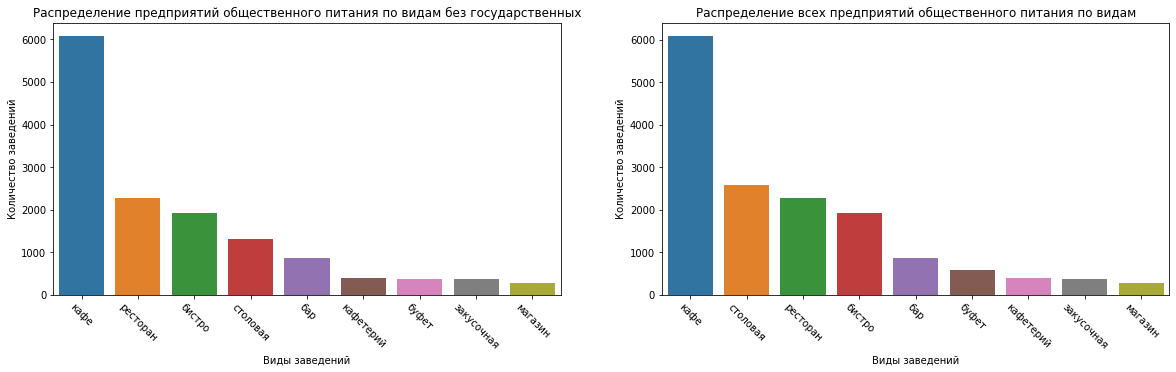

In [8]:
counts_facility = rest_df_no_state['object_type'].value_counts().reset_index()
counts_facility_all = rest_df['object_type'].value_counts().reset_index()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.barplot(ax=axs[0], x="index", y="object_type", data=counts_facility)
sns.barplot(ax=axs[1], x="index", y="object_type", data=counts_facility_all)

[ax.set_xlabel("Виды заведений") for ax in [axs[0], axs[1]]]
axs[0].set_title("Распределение предприятий общественного питания по видам без государственных")
axs[1].set_title("Распределение всех предприятий общественного питания по видам")
[ax.set_ylabel("Количество заведений") for ax in [axs[0], axs[1]]]
[ax.set_xticklabels(ax.get_xticklabels(), rotation=-45) for ax in [axs[0], axs[1]]];

Два графика выше отличаются данными, используемыми для их построения, для построения правого графика используются данные только не государственных учреждений питания. Эти графики демонстрируют различие в количестве всех заведений и количестве государственных.

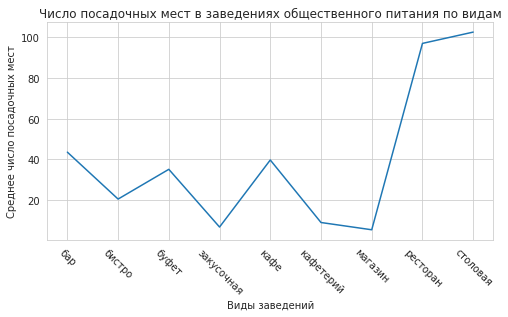

In [9]:
count_number_by_type = np.round(pd.pivot_table(rest_df_no_state.loc[:,['object_type', 'number']],
                    values='number', index=['object_type'], aggfunc=[np.mean]).reset_index(), 2)

count_number_by_type.columns = ['object_type', 'mean_numbers']

plt.figure(figsize=(8, 4))
sns.set_style("whitegrid") 
ax = sns.lineplot(x="object_type", y="mean_numbers", data=count_number_by_type) 

ax.set_xlabel("Виды заведений")
ax.set_title("Число посадочных мест в заведениях общественного питания по видам")
ax.set_ylabel("Среднее число посадочных мест")
plt.xticks(rotation=-45);

### Вывод 
- Формат столовой и ресторана предполагает прием пищи в самом заведении, в связи с чем численность посадочных мест в среднем выше других видов;
- В ресторанах зачастую не только едят, в связи с чем среднее время посещения возрастает, а для поддержания бОльшего числа посетителей необходимо увеличивать число посадочных мест;
- Доминирование численности объектов кафе может заключаться в широком значении такого вида объекта, также это слово нейтрально;
- Закусочная - слово с несколько негативным оттенком, что уменьшает число владельцев называющих заведения таким видом;
- Большое число столовых в городе - государственные;
- Кажется, что количество отделов кулинарии в Москве сильно больше 272.

### Закономерности в сетевых заведениях <a name="network"></a>

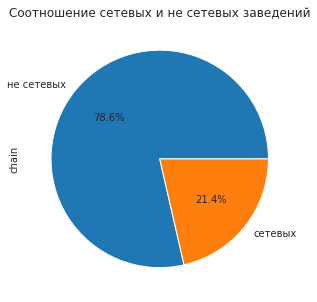

In [10]:
plot_platforms_eu = rest_df_no_state['chain'].value_counts().rename({'нет': 'не сетевых', 'да': 'сетевых'}).\
plot.pie(subplots=True, figsize=(5, 5),autopct='%1.1f%%')
plt.title('Соотношение сетевых и не сетевых заведений');

Вид объекта общественного питания, которому характерно сетевое распространение и количество таких заведений

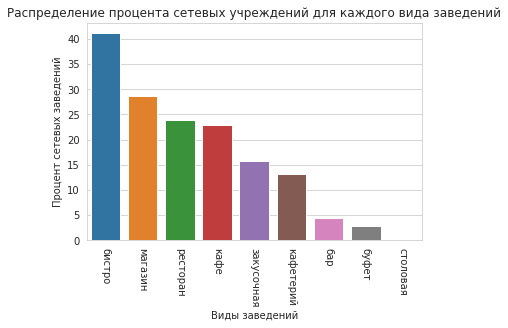

In [11]:
percentage_types = rest_df_no_state.query('chain == "да"')['object_type'].value_counts() \
/ rest_df_no_state['object_type'].value_counts()
percentage_types *= 100
percentage_types = percentage_types.reset_index().sort_values('object_type', ascending=False)

ax = sns.barplot(x="index", y="object_type", data=percentage_types)
ax.set_xlabel("Виды заведений")
ax.set_title("Распределение процента сетевых учреждений для каждого вида заведений")
ax.set_ylabel("Процент сетевых заведений")
ax.set_xticklabels(ax.get_xticklabels(), rotation=-90);

In [12]:
info_about_network = pd.pivot_table(rest_df_no_state.query('chain == "да"').loc[:,['object_name', 'number']],
                    values='number', index=['object_name'], aggfunc=['count', 'median', np.mean, np.min, np.max]).reset_index()

info_about_network.columns = ['object_name', 'count_places', 'median_persons', 'mean_persons', 'min_persons', 'max_persons']
info_about_network['mean_persons'] = round(info_about_network['mean_persons'], 2)
info_about_network.sort_values('count_places', ascending=False).head(10)

,object_name,count_places,median_persons,mean_persons,min_persons,max_persons
439,шоколадница,173,50.0,57.24,7,150
25,kfc,170,46.5,55.07,0,400
244,макдоналдс,166,79.0,88.54,0,580
102,бургер кинг,144,45.0,46.92,0,150
395,теремок,105,24.0,26.64,0,200
225,крошка картошка,92,15.0,21.78,0,120
157,домино'с пицца,92,16.0,18.27,4,50
379,суши wok,75,6.0,6.75,0,22
254,милти,72,0.0,1.33,0,40
282,папа джонс,53,20.0,21.89,0,63


In [13]:
print('{:.2%} - процент сетевых заведений первых 10 самых популярных сетей'.format(info_about_network.
        sort_values('count_places', ascending=False).head(10)['count_places'].sum() / info_about_network['count_places'].sum()))

38.48% - процент сетевых заведений первых 10 самых популярных сетей


In [14]:
print('{} - количество сетей с одним заведением'.format(info_about_network.query('count_places == 1')['count_places'].count()))
print(info_about_network['count_places'].describe())

info_about_network.query('count_places > 1')['count_places'].describe()

236 - количество сетей с одним заведением
count    454.000000
mean     6.537445  
std      18.883801 
min      1.000000  
25%      1.000000  
50%      1.000000  
75%      4.000000  
max      173.000000
Name: count_places, dtype: float64


count    218.000000
mean     12.532110 
std      25.980166 
min      2.000000  
25%      2.000000  
50%      4.000000  
75%      9.000000  
max      173.000000
Name: count_places, dtype: float64

### Вывод о сетевых заведениях

* 78.6% заведений являются не сетевыми;
* Более половины сетей состоят из 1 заведения и рассматривать их как сеть считаю не целесообразным;
* Большое число сетей имеет малое количество заведений в связи с чем возможно рассмотрение характерности числа посадочных мест сетей с точки зрения сети с медианным числом заведений или же с точки зрения действительно больших сетей, я рассматривал со второй позиции;
* В крупных сетях большой разброс численности посадочных мест, что говорит о множестве вариантов организации общественного питания в зависимости от внешних факторов;
* Среди крупных сетей есть сети похожие друг на друга по ассортименту при этом их медианное число посетителей также близко, к примеру бургер кинг и kfc, домино'с пицца и папа джонс.

### Выявление популярных районов <a name='pop_districts'></a>


In [15]:
info_about_address =  rest_df_no_state['address'].str.split(", ", expand=True)

street_arr = []
name_part_address = ['дом', 'владение', 'домовладение', 'корпус', 'строение']

# цикл по заведениям, которые не государственные 
for counter in (info_about_address.index):
    flag_Moscow = info_about_address.loc[counter, 0] == 'город Москва'
    insert_flag = False
    
    # Поиск слова, обозначающего номер дома
    for counter_columns in range(1, len(info_about_address.columns) - 1):
        if insert_flag:
            break
        
        # Перебор всевозможных синонимов слова дом, корпус и строение корректны в этом смысле, так как это не всегда приписки 
        for home in name_part_address:
            if info_about_address.loc[counter, counter_columns].find(home) != -1:
                
                # Считаю, что всё, что написано до дома за исключением города адрес типо улицы
                street_arr.append(' '.join([str(element) 
                                        for element in info_about_address.loc[counter, flag_Moscow:counter_columns-1].values]))

                insert_flag = True
                break

rest_df_no_state.loc[:, 'street'] = street_arr
top_10_streets = rest_df_no_state['street'].value_counts().head(10)

In [16]:
# Получение координат при помощи api по адресам
def get_geo_info_about_homes(array_parts_address, api_key, tag):
    adress_list = []

    # Перебор всех адресов и получение их параметров, координат по адресу или района по координатам
    for address_part in array_parts_address:
        try:

            # В случае надобности координат и районов запросы несколько отличаются
            if tag == 'formatted':
                URL_for_request = 'https://geocode-maps.yandex.ru/1.x/?apikey={}&kind=district&geocode='.format(api_key) + address_part
            else:
                URL_for_request = 'https://geocode-maps.yandex.ru/1.x/?apikey={}&geocode='.format(api_key) + address_part

            data_for_request = requests.get(URL_for_request).text           
            result_requests = re.search(f'<{tag}>(.*?)<', data_for_request).group(1)
            adress_list.append(result_requests)
        except:
            adress_list.append('invalid geo')
            print(address_part)

    return adress_list

In [17]:
# Получение dataFrame из таблицы с google диска 
def get_df_from_csv(spreadsheet_id):
    file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
    request = requests.get(file_name)
    df = pd.read_csv(BytesIO(request.content))

    return df

In [18]:
# Функция удаления излишней детализации районов
def get_dict_disctricts_and_cut_excess(more_districts):
    dict_districts = { }

    for element_arr in more_districts:
        
        # Блок с try, по причине наличия адресов, для которых не определяются корректно координаты
        try:

            dict_districts[element_arr] = re.match(
                r'(.*?, (поселение [а-яА-Яё ]*),?|.+?, ([а-яА-Яё ]*район[а-яА-Яё ]*,?))', element_arr).group(3)
            if dict_districts[element_arr][-1] == ',':
                dict_districts[element_arr] = dict_districts[element_arr][:-int(dict_districts[element_arr][-1] == ',')]
        except:

            dict_districts[element_arr] = 'invalid'
    return dict_districts

In [19]:
# Создание промежуточного файла вынужденная мера по причине ограничение на число бесплатных запросов в день
# Эта и нижняя ячейка отражают последовательность выполненных действий, но являются промежуточными результатами
# top_10_streets = top_10_streets.index
# info_about_popular_places = rest_df_no_state.query('street in @top_10_streets')['address'].to_frame()

# info_about_popular_places.loc[:,'coordinates'] = get_geo_info_about_homes(info_about_popular_places['address'].values, \
#    api_key, 'pos')

# info_about_popular_places.to_csv('coordinates_popular_places.csv', sep=';', encoding='utf-8-sig')

In [20]:
# Использование файла с координатами для получения районов популярных мест
# info_about_popular_places = get_df_from_csv('1ggoSJjtSUDjE2211LNojHDoywYfNSeG5kkgvA4_uL0U')

# info_about_popular_places.loc[:,'districts'] = get_geo_info_about_homes(info_about_popular_places['coordinates'].values, \
#    api_key,  'formatted')

# info_about_popular_places = info_about_popular_places.drop(['coordinates'], axis=1)
# info_about_popular_places.to_csv('districts_popular_places.csv', sep=';', encoding='utf-8-sig')

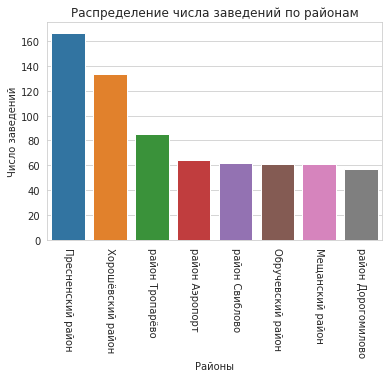

In [21]:
# Получение районов по 10 улицам с наибольшим числом заведений
address_with_districts = get_df_from_csv('1-D76LdBuxyYiYRE2JL6VeOTiUozgSyzMxoMpuxmAfMg')

dict_districts = get_dict_disctricts_and_cut_excess(address_with_districts['districts'].unique())
address_with_districts['districts'] = address_with_districts['districts'].map(dict_districts)
address_with_districts['districts'].value_counts().head(8).to_frame()

ax = sns.barplot(x="index", y="districts",
                 data=address_with_districts['districts'].value_counts().head(8).to_frame().reset_index())
ax.set_xlabel("Pайоны")
ax.set_title("Распределение числа заведений по районам")
ax.set_ylabel("Число заведений")
ax.set_xticklabels(ax.get_xticklabels(), rotation=-90);

### Выводы о районах

Выше приведен топ 8 районов по числу заведений, именно восемь, так как в таком случае отличие самого популярного и не популярного района менее чем в три раза. 

* В разных районах сильно отличается количество заведений;
* Первые два района по количеству заведений сильно отличаются от остальных, территориально они находятся рядом друг с другом;

Причины большого числа заведений в Пресненском районе:
* Содержит деловой центр «Москва-Сити» — развивающийся деловой район в Москве на Пресненской набережной, в котором большое число организаций, высокая плотность рабочих мест;
* Включает в себя множество историко-архитектурных памятников;
* Расположены объекты федерального и общегородского значения.

Причины большого числа заведений в Хорошёвском районе:
* Наличие самого большого ТРЦ всей Европы, по официальной информации на сайте, лишь на его территории 81 ресторан;
* Наличие крупного стадиона в районе.

### Выявление закономерностей заведений в популярных районax <a name='pop_districts_depend'></a>


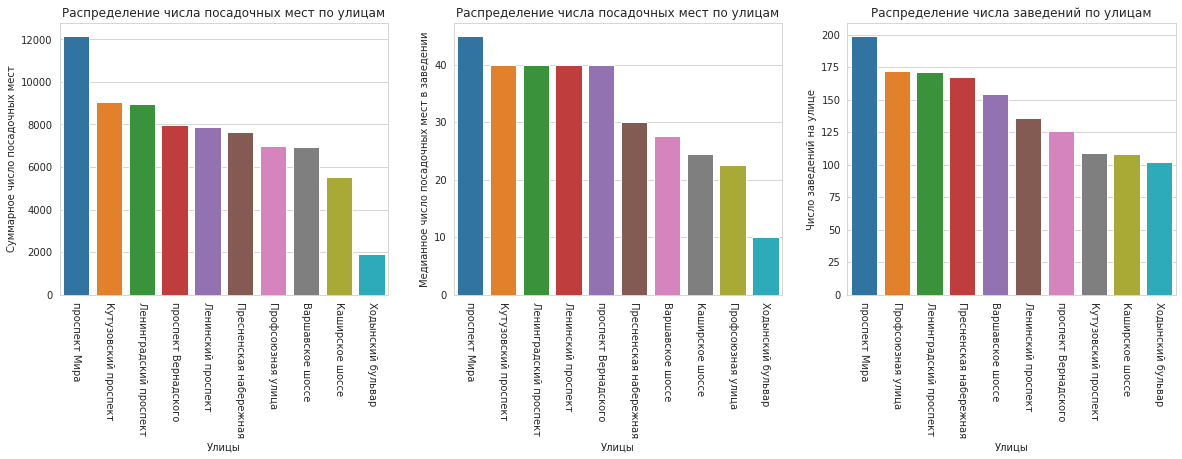

In [22]:
try:
    top_10_streets = top_10_streets.index
except:
    print('Уже нет индекса')
number_by_street = rest_df_no_state.query('street in @top_10_streets').groupby('street')['number'].\
        agg(['sum', np.median, 'count']).reset_index()

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
sns.barplot(ax=axs[0], x="street", y="sum", data=number_by_street.sort_values('sum', ascending=False))
sns.barplot(ax=axs[1], x="street", y="median", data=number_by_street.sort_values('median', ascending=False))
sns.barplot(ax=axs[2], x="street", y="count", data=number_by_street.sort_values('count', ascending=False))

axs[0].set_xlabel("Улицы")
axs[0].set_title("Распределение числа посадочных мест по улицам")
axs[0].set_ylabel("Суммарное число посадочных мест")
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=-90);

axs[1].set_xlabel("Улицы")
axs[1].set_title("Распределение числа посадочных мест по улицам")
axs[1].set_ylabel("Медианное число посадочных мест в заведении")
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=-90);

axs[2].set_xlabel("Улицы")
axs[2].set_title("Распределение числа заведений по улицам")
axs[2].set_ylabel("Число заведений на улице")
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=-90);

### Выявление районов с улицами, на которых один вид заведений <a name = 'districts_1_inst'></a>


In [23]:
streets_with_one_type = rest_df_no_state.groupby(['street'])['object_type'].nunique().\
            to_frame().query('object_type == 1').index

print(f'{len(streets_with_one_type)} - количество улиц с одним видом заведений')

721 - количество улиц с одним видом заведений


In [24]:
# Выделение районов для улиц с единственным видом заведений 
# one_type_institute_df = rest_df_no_state.query('street in @streets_with_one_type')['address', 'street']
# one_type_institute_df.loc[:,'coordinates'] = get_geo_info_about_homes(one_type_institute_df['address'].values, api_key, 'pos')
# one_type_institute_df = one_type_institute_df.query('coordinates != "invalid geo"')

# one_type_institute_df.loc[:, 'districts'] = /
# get_geo_info_about_homes(one_type_institute_df['coordinates'].values, api_key, 'formatted')
# one_type_institute_df = one_type_institute_df.query('districts != "invalid geo"')
# one_type_institute_df = one_type_institute_df.drop(['coordinates', 'address'], axis=1)
# one_type_institute_df.to_csv('districts_one_type_institute.csv', sep=';', encoding='utf-8-sig')

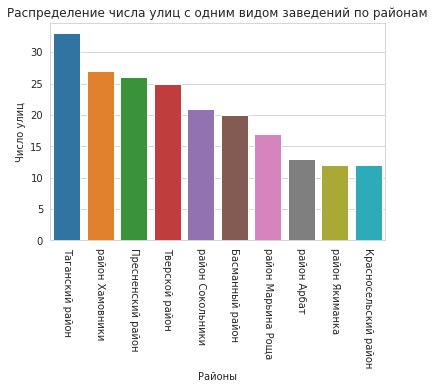

In [25]:
one_type_institute_df = get_df_from_csv('1qwNgTNqImro8rv2P-ERTCR-G8n1ZUy6wCHUfn0dAFAs')
dict_districts = get_dict_disctricts_and_cut_excess(one_type_institute_df['districts'].unique())

one_type_institute_df['districts'] = one_type_institute_df['districts'].map(dict_districts)
one_type_institute_df = one_type_institute_df.query('districts != "invalid"')
one_type_institute_df.groupby('districts')['street'].nunique().sort_values(ascending=False).head(10)

ax = sns.barplot(x="districts", y="street", data=one_type_institute_df.groupby('districts')['street']. \
                 nunique().sort_values(ascending=False).head(10).to_frame().reset_index())
ax.set_xlabel("Pайоны")
ax.set_title("Распределение числа улиц с одним видом заведений по районам")
ax.set_ylabel("Число улиц")
ax.set_xticklabels(ax.get_xticklabels(), rotation=-90);

* На 721 улице располагаются заведения одного вида;
* Существуют некоторые районы, в которых таких улиц больше, чем в других;
* Считаю этот показатель малоэффективным для рассмотрения и последующего прогнозирования.


## Общий вывод <a name='conclusion'></a>

Выявлены ряд закономерностей, которые необходимо учесть при создании собственного кафе:

* При выборе вида заведения рекомендую обратить внимание на следующие факторы:
  * Формат столовой и ресторана предполагает прием пищи в самом заведении, в связи с чем необходимо закладывать большую численность посадочных мест, а значит и большую площадь заведения;
  * В ресторанах зачастую не только едят, в связи с чем среднее время посещения возрастает, а для поддержания бОльшего числа  посетителей необходимо увеличивать число посадочных мест;
  * Закусочная, столовая - слова с несколько негативным оттенком, что уменьшает число владельцев называющих заведения такими видами, рекомендую не открывать заведения подобного вида;
  * Отделы кулинарии в Москве - самый не популярный вид заведений, кафе напротив, встречается чаще других.


* Размышляя о сетевом аспекте следует обратить внимание на следующее:
    * 78.6% заведений являются не сетевыми, что говорит о некоторых проблемах в распространении концепций на сеть заведений;
    * Большое число сетей имеет малое количество заведений в связи с чем, рекомендую остановиться на открытии одного заведения, а не сразу сети, для отработки системы функционирования;
    * С другой стороны в крупных сетях существуют очень разные заведения - киоски и огромные пространства на сотни человек, каждый вид заведения уместен в конкретных условиях, так что необходимо максимально тщательно изучить место будущего заведения;
    * Среди крупных сетей есть сети похожие друг на друга по ассортименту при этом их медианное число посетителей также близко, поэтому при открытии заведения можно поискать похожие успешные предприятия и взаимствовать какие-то идеи.
    
    
* Что касается района будущего заведения:
   * В разных районах сильно отличается количество заведений;
   * На численность посадочных мест влияет множество историко-архитектурных памятников, объекты федерального и общегородского значения, плотность населения, наличие иных крупных сооружений;
   * Может иметь место зависимость событий и наплыва посетителей, концерты, матчи спортивных команд;
   * Необходимо не забывать анализировать платежеспособность посетителей.
   
   
 * Возможные влияния формата:
   * Готовность - доверие социума к таким сотрудникам, необходимо узнать настроение людей, стоит хотя бы опрос провести об отношении людей к роботам; 
   * Чаевые, рестораны и кафе с официантами экономят на зарплате, так как чаевые посетителей являются достойной заменой, будут ли оставлять клиенты роботам на чай - вопрос отдельного исследования;
   * Необходимо напирать на плюсы формата, как по мне главное - это стабильность, стабильный вкус, так как возможно обрабатывать продукты, стабильное время ожидания, стабильно высокий сервис.


Открытие заведения - сложная задача и необходимо анализировать массу факторов, проведя анализ были выявлены лишь некоторые общие закономерности и перед открытием рекомендую провести дополнительное исследование об отношении к формату, поиску похожих примеров.

Презентация: https://drive.google.com/file/d/10ZQ_p0rZw_ROYMifbN0jGrjATcO7VVyh/view?usp=sharing